In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.17.1


**Fixing randomness**

In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### No warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **Dataset**




The preprocessing script prepares the dataset by removing outliers, balancing classes, applying augmentation, and splitting it into training and validation sets.

Here we imported them and load into images and labels.

In [ ]:
from tensorflow.keras.utils import to_categorical
dataset_path_train = '/content/drive/MyDrive/Homework1/dataset/FINAL/full_set_StrongAugmentation_WithSoftCutMix_WithColorDegradation_Balanced/train_set_Unified.npz'
dataset_path_val = '/content/drive/MyDrive/Homework1/dataset/npz_NoTestSet/filtered_classes_noOutliears/val_set.npz'

data = np.load(dataset_path_train)
X_train = data['images']
y_train_flatten = data['labels'].flatten()
y_train = to_categorical(y_train_flatten, num_classes=8)

data = np.load(dataset_path_val)
X_val = data['images']
y_val_flatten = data['labels'].flatten()
y_val = to_categorical(y_val_flatten, num_classes=8)


Apply some further basic augumentation to enhance diversity in the dataset.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.2, fill_mode='reflect'),
    tf.keras.layers.RandomZoom(height_factor=0.3, width_factor=0.3, fill_mode='reflect'),
    tf.keras.layers.RandomTranslation(height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3), fill_mode='reflect'),  # Added translation
], name='data_augmentation')

Plot some random images to check the imported dataset.

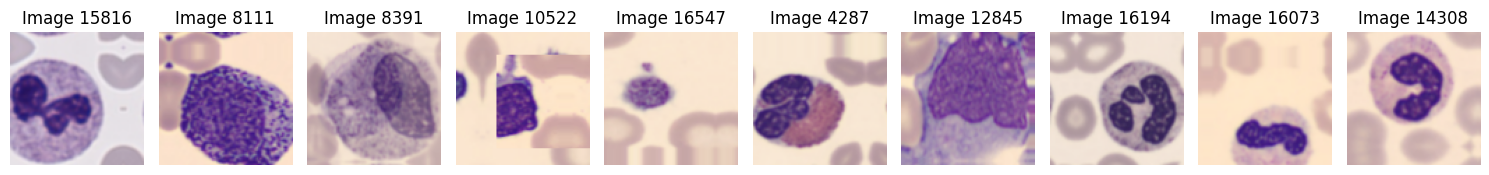

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_images(X_train, num_images=10):
    # Ensure X_train is a numpy array
    X_train = np.array(X_train)

    # Randomly select indices
    random_indices = np.random.choice(len(X_train), size=num_images, replace=False)
    selected_images = X_train[random_indices]

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, ax in enumerate(axes):
        if selected_images[i].ndim == 2:  # Grayscale images
            ax.imshow(selected_images[i], cmap='gray')
        else:  # RGB or other formats
            ax.imshow(selected_images[i])
        ax.axis('off')
        ax.set_title(f"Image {random_indices[i]}")

    plt.tight_layout()
    plt.show()

# Example usage
plot_random_images(X_train)

# **Transfer Learning**

In [ ]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 50

## Model Architecture

We import ConvNeXtLarge without top and we preprocess our data with the preprocess function of the imported net.

In [ ]:
supernet = tf.keras.applications.convnext.ConvNeXtLarge(
    input_shape = input_shape,
    include_top = False,
    weights='imagenet'
)

supernet.trainable = False

X_train = tf.keras.applications.convnext.preprocess_input(X_train)
X_val = tf.keras.applications.convnext.preprocess_input(X_val)

print(X_train.min(), X_train.max())

785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step
9 254


In [ ]:
input_layer = tfkl.Input(input_shape)

x = tfkl.Resizing(height = 224, width = 224, interpolation = 'bilinear' )(input_layer)
x = data_augmentation(input_layer)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(rate=0.39)(x)
x = tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(rate=0.33)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):

    callbacks = []

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=19, restore_best_weights=True)

    callbacks.append(es_callback)
    return callbacks

**Class Weight**

Use manual class weights to fix already experienced biases in the model.

In [ ]:
from sklearn.utils import class_weight
import tensorflow as tf

# Compute class weights based on y_train_flatten
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatten),
    y=y_train_flatten
)

# Convert to dictionary format
#class_weights_dict = dict(enumerate(class_weights))

# Manually set class weights
class_weights_dict = {
    0: 1.0,
    1: 1.0,
    2: 1.1,
    3: 1.2,
    4: 1.5,
    5: 1.5,
    6: 1.0,
    7: 1.1
}

# Print the computed class weights
print(class_weights_dict)

{0: 1.0, 1: 1.0, 2: 1.1, 3: 1.2, 4: 1.5, 5: 1.5, 6: 1.0, 7: 1.1}


In [ ]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_large (Functional)          │ (None, 3, 3, 1536)          │     196,230,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,083,976 (751.82 MB)

 Trainable params: 853,640 (3.26 MB)

 Non-trainable params: 196,230,336 (748.56 MB)

**In Transfer Learning first phase do not unfreeze any layer.**

In [ ]:
# Print all layers in the ConvNeXtLarge model
for i, layer in enumerate(supernet.layers):
    print(i, layer.name, layer.trainable)

# Alternatively, if you want to see all layers in the final model, including those of ConvNeXtLarge:
print("\n--- Entire Model Layers ---")
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

# If you specifically want to isolate 'supernet' layers in the full model:
print("\n--- Supernet Layers in Full Model ---")
supernet_layers = model.get_layer(name='convnext_large').layers
for i, layer in enumerate(supernet_layers):
    print(i, layer.name, layer.trainable)


0 input_layer False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 convnext_large_stage_0_block_1_depthwise_conv False
11 convnext_large_stage_0_block_1_layernorm False
12 convnext_large_stage_0_block_1_pointwise_conv_1 False
13 convnext_large_stage_0_block_1_gelu False
14 convnext_large_stage_0_block_1_pointwise_conv_2 False
15 convnext_large_stage_0_block_1_layer_scale False
16 convnext_large_stage_0_block_1_identity False
17 convnext_large_stage_0_block_2_depthwise_conv False
18 convnext_large_stage_0_block_2_layernorm False
19 convnext_large_stage_0_block_2_pointwise_conv_1 False
20 convnext_large_stag

##Import the net to further training

We had to reimport the net due to COlab Limitations.

In [ ]:
#Imported Net
model_path = '/content/drive/My Drive/Homework1/net_output/PROVAGPU/'

# Load the model
model = tf.keras.models.load_model(model_path)
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(3.906e-06), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau

class SaveEveryNEpochs(Callback):
    def __init__(self, save_freq, model_filepath):
        super(SaveEveryNEpochs, self).__init__()
        self.save_freq = save_freq
        self.model_filepath = model_filepath

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.model_filepath.format(epoch=epoch + 1)
            self.model.save(filepath)
            print(f"\nModel saved at: {filepath}")

# Define the directory and file pattern for saving models
output_dir = '/content/drive/My Drive/Homework1/net_output/PROVAGPU/'
model_checkpoint_pattern = f'{output_dir}/FinalConvNext{{epoch:02d}}.keras'


# Create the custom callback to save every 5 epochs
save_every_10_epochs = SaveEveryNEpochs(
    save_freq=20,
    model_filepath=model_checkpoint_pattern
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=2,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,         # Minimum learning rate
    verbose=1            # Prints a message when the learning rate is reduced
)

# Train the model with the custom callback
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[save_every_10_epochs, reduce_lr],
).history

print(f"Models will be saved every 10 epochs in the directory: {output_dir}")

Epoch 1/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.5017 - loss: 14.2504 - val_accuracy: 0.7479 - val_loss: 2.4497 - learning_rate: 0.0010
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.6894 - loss: 2.3582 - val_accuracy: 0.4373 - val_loss: 2.4625 - learning_rate: 0.0010
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.7467 - loss: 1.7040 - val_accuracy: 0.8170 - val_loss: 1.2542 - learning_rate: 0.0010
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.7580 - loss: 1.4756 - val_accuracy: 0.7401 - val_loss: 1.2865 - learning_rate: 0.0010
Epoch 5/50
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7732 - loss: 1.3660
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
583/583 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.7732 - loss: 1.3660 - val_accuracy: 0.7345 - val_loss: 1.3489 - learning_rate: 0.0010
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.7866 - lo

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

NameError: name 'history' is not defined

<Figure size 1500x500 with 0 Axes>

In [ ]:

output_dir = '/content/drive/My Drive/Homework1/net_output/PROVAGPU'  # Directory to save logs, plots, and models


# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/FinalConvNext30.keras'
model.save(model_filename)
print(f"Model saved at {model_filename}")

Model saved at /content/drive/My Drive/Homework1/net_output/PROVAGPU/FinalConvNext30.keras


# **Fine Tuning**

**Here we applied fine tuning from the previous network.**

In [ ]:
#initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 200

##IMPORT MODEL

We had to import the model from outside savings due to Colab limitations.

In [ ]:
output_dir = '/content/drive/My Drive/Homework1/net_output/PROVAGPU'  # Directory to save logs, plots, and models

# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/FinalConvNext30s'

model = tf.keras.models.load_model(model_filename)

Unfreeze only 50% of the network.

In [ ]:
def unfreeze_fraction_of_layers(model, fraction):
    """Unfreezes a fraction of layers in the model, starting from the end.

    Args:
        model: The Keras model.
        fraction: The fraction of layers to unfreeze (e.g., 0.10 for 10%).
    """
    total_layers = len(model.layers)
    num_layers_to_unfreeze = int(fraction * total_layers)
    start_unfreeze_index = total_layers - num_layers_to_unfreeze

    for i in range(start_unfreeze_index, total_layers):
        layer = model.layers[i]
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    print(f"Unfroze {num_layers_to_unfreeze} layers ({fraction:.2%} of total layers).")

def freeze_all_layers(model):
    """Freezes all layers in the model, including those within sub-models."""
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):  # If it's a sub-model, recurse
            freeze_all_layers(layer)
        else:
            layer.trainable = False

    print("All layers in the model have been frozen.")

convnext_submodel = model.get_layer('convnext_large')
freeze_all_layers(convnext_submodel)
# Assuming 'model' is your Keras model
unfreeze_fraction_of_layers(convnext_submodel, 0.1)# Unfreeze 10% of layers


model.summary()

All layers in the model have been frozen.
All layers in the model have been frozen.
All layers in the model have been frozen.
All layers in the model have been frozen.
All layers in the model have been frozen.
Unfroze 129 layers (50.00% of total layers).


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_large (Functional)          │ (None, 3, 3, 1536)          │     196,230,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,791,258 (758.33 MB)

 Trainable params: 129,194,120 (492.84 MB)

 Non-trainable params: 67,889,856 (258.98 MB)

 Optimizer params: 1,707,282 (6.51 MB)

##USE MODEL (inside RAM)

We were not able to actually use this block during our trainigs due to Colab limitations.

In [ ]:
for i, layer in enumerate(model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_layer_14 True
1 convnext_large_prestem_normalization False
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 convnext_large_stage_0_block_1_depthwise_conv False
11 convnext_large_stage_0_block_1_layernorm False
12 convnext_large_stage_0_block_1_pointwise_conv_1 False
13 convnext_large_stage_0_block_1_gelu False
14 convnext_large_stage_0_block_1_pointwise_conv_2 False
15 convnext_large_stage_0_block_1_layer_scale False
16 convnext_large_stage_0_block_1_identity False
17 convnext_large_stage_0_block_2_depthwise_conv False
18 convnext_large_stage_0_block_2_layernorm False
19 convnext_large_stage_0_block_2_pointwise_conv_1 False
20 convnext_large_sta

##Class Weight

Use manual class weights to fix already experienced biases in the model as the classes are already balanced in preprocessing.

In [ ]:
from sklearn.utils import class_weight
import tensorflow as tf

# Compute class weights based on y_train_flatten
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatten),
    y=y_train_flatten
)

# Convert to dictionary format
#class_weights_dict = dict(enumerate(class_weights))

# Manually set class weights
class_weights_dict = {
    0: 1.0,
    1: 1.0,
    2: 1.1,
    3: 1.2,
    4: 1.5,
    5: 1.5,
    6: 1.0,
    7: 1.1
}

# Print the computed class weights
print(class_weights_dict)
model.summary()

{0: 1.0, 1: 1.0, 2: 1.1, 3: 1.2, 4: 1.5, 5: 1.5, 6: 1.0, 7: 1.1}


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_large (Functional)          │ (None, 3, 3, 1536)          │     196,230,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,791,258 (758.33 MB)

 Trainable params: 129,194,120 (492.84 MB)

 Non-trainable params: 67,889,856 (258.98 MB)

 Optimizer params: 1,707,282 (6.51 MB)

##Train

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['accuracy'])

model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_large (Functional)          │ (None, 3, 3, 1536)          │     196,230,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,083,976 (751.82 MB)

 Trainable params: 129,194,120 (492.84 MB)

 Non-trainable params: 67,889,856 (258.98 MB)

Here we implement Checkpoints for intermediate savings and ReduceLROnPlateau for dynamic learning rate adjustment.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau


class SaveEveryNEpochs(Callback):
    def __init__(self, save_freq, model_filepath):
        super(SaveEveryNEpochs, self).__init__()
        self.save_freq = save_freq
        self.model_filepath = model_filepath

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.model_filepath.format(epoch=epoch + 1)
            self.model.save(filepath)
            print(f"\nModel saved at: {filepath}")

# Define the directory and file pattern for saving models
output_dir = '/content/drive/My Drive/Homework1/net_output/PROVAGPU'
model_checkpoint_pattern = f'{output_dir}/FinalConvNext_2FineTuning_epoch{{epoch:02d}}.keras'


# Create the custom callback to save every 5 epochs
save_every_5_epochs = SaveEveryNEpochs(
    save_freq=15,
    model_filepath=model_checkpoint_pattern
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Metric to monitor
    factor=0.25,          # Factor by which the learning rate will be reduced
    patience=2,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,         # Minimum learning rate
    verbose=1            # Prints a message when the learning rate is reduced
)

# Train the model with the custom callback
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[save_every_5_epochs, reduce_lr],
).history

print(f"Models will be saved every 5 epochs in the directory: {output_dir}")


Epoch 1/200
583/583 ━━━━━━━━━━━━━━━━━━━━ 212s 302ms/step - accuracy: 0.8250 - loss: 1.1408 - val_accuracy: 0.9613 - val_loss: 0.3738 - learning_rate: 0.0010
Epoch 2/200
583/583 ━━━━━━━━━━━━━━━━━━━━ 165s 283ms/step - accuracy: 0.9455 - loss: 0.4689 - val_accuracy: 0.9802 - val_loss: 0.2806 - learning_rate: 0.0010
Epoch 3/200
583/583 ━━━━━━━━━━━━━━━━━━━━ 165s 283ms/step - accuracy: 0.9551 - loss: 0.3974 - val_accuracy: 0.9764 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 4/200
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9646 - loss: 0.3542
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
583/583 ━━━━━━━━━━━━━━━━━━━━ 165s 283ms/step - accuracy: 0.9646 - loss: 0.3541 - val_accuracy: 0.9635 - val_loss: 0.3034 - learning_rate: 0.0010
Epoch 5/200
583/583 ━━━━━━━━━━━━━━━━━━━━ 165s 283ms/step - accuracy: 0.9767 - loss: 0.1999 - val_accuracy: 0.9639 - val_loss: 0.2147 - learning_rate: 2.5000e-04
Epoch 6/200
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - a

KeyboardInterrupt: 

In [ ]:
output_dir = '/content/drive/My Drive/Homework1/net_output/ConvNext'


# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/ConvNext_epoch02_FullSet_SoftCutMixAug_withColorDegradation_LRPlateau_FineTuning.keras'
model.save(model_filename)
print(f"Model saved at {model_filename}")

Model saved at /content/drive/My Drive/Homework1/net_output/ConvNext/ConvNext_epoch02_FullSet_SoftCutMixAug_withColorDegradation_LRPlateau_FineTuning.keras
